# Imports

In [1]:
import os
import tempfile
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn as skl
import joblib
import json
import pickle
import tempfile
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from collections import defaultdict
import joblib

from data_functions import ingest_data, prepare_data

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 4321
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Check GPU
physical_devices = tf.config.list_physical_devices('GPU')
print('TF version:',tf.__version__ ,  tf.config.experimental.list_physical_devices(device_type='GPU') )

#memory control 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

TF version: 2.1.0 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#Azure Imports
import azureml.core
from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core import Experiment
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.webservice import AciWebservice
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.resource_configuration import ResourceConfiguration
from azureml.core.model import InferenceConfig
#from azureml.core.webservice import AksWebservice
from azureml.core.environment import Environment, DEFAULT_CPU_IMAGE   #, DEFAULT_GPU_IMAGE
from azureml.core.compute import ComputeTarget #, AksCompute
from azureml.core.compute_target import ComputeTargetException
#from azureml.core.datastore import Datastore
from msrest.exceptions import HttpOperationError
from azureml.core.webservice import LocalWebservice

print('Azure version:', azureml.core.VERSION)

Azure version: 1.19.0


# Connect to Azure

In [4]:
ws_name ='Prototype' 
sub_id ='xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx'  #your subscription ID
res_grp ='Deploy'
region ='South Central US'

subscription_id = os.getenv("SUBSCRIPTION_ID", default= sub_id)
resource_group = os.getenv("RESOURCE_GROUP", default=  res_grp)
workspace_name = os.getenv("WORKSPACE_NAME", default=  ws_name)
workspace_region = os.getenv("WORKSPACE_REGION", default=  region)

In [5]:
#connect to workspace or create a new workspace
try:
    ws = Workspace.from_config()
    print("Workspace succesfully loaded from config")
except:
    print("CANNOT create workspace from config file, creating new workspace")
    ws = Workspace.create(name = ws_name, subscription_id = sub_id, resource_group=res_grp, 
                              create_resource_group=True, location= region)
    ws.write_config()
# print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')   # prints details of workspace

Workspace succesfully loaded from config


In [ ]:
#displays compute targets, optional
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print(compute.name, ":", compute.type)

# Import Data

In [6]:
user_df = pd.read_csv('data/user_df.csv')
user_df.head(2)

,user_id,cat1,cat2,cat3,numeric1,target
0,1,1,1,1,2.855963,0.698282
1,1,2,1,2,0.603192,0.243984


In [7]:
live_df = pd.read_csv('data/live_df.csv')
live_df.head(2)

,user_id,cat1,cat2,cat3,numeric1,target
0,95,1,1,1,4.731038,0.508188
1,95,2,1,2,4.065228,0.189716


In [8]:
test_df = pd.read_csv('data/prediction_df.csv')
test_df.head(2)

,user_id,cat1,cat2,cat3,numeric1
0,95,102,3,30,0.101255
1,95,63,2,17,2.882782


In [9]:
recommender_df = pd.read_csv('data/recommender_df.csv')
recommender_df.head(2)

,user_id,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,...,cat_111,cat_112,cat_113,cat_114,cat_115,cat_116,cat_117,cat_118,cat_119,cat_120
0,1,0.611919,0.076709,0.940055,0.789101,0.523699,0.103797,0.753127,0.670991,0.905431,...,0.647340,0.142626,0.302712,0.201463,0.652526,0.191534,0.287450,0.648126,0.793318,0.920860
1,2,0.354930,0.200342,0.405535,0.665751,0.765351,0.809228,0.599576,0.921978,0.480865,...,0.991894,0.552732,0.391137,0.966449,0.120969,0.948793,0.657196,0.480267,0.909870,0.516444


# TF Model

In [10]:

def create_model(cat_features, num_features, data):
    '''
    Create tf model.
    input: df and list of categorical features
    output: tf model
    '''
    models= []
    inputs = []
    for cat in cat_features:
        vocab_size = (data[cat].nunique()) + 1  #//2
        inpt = tf.keras.layers.Input(shape=(1,),name='input_'+'_'.join(cat.split(' ')))
        inputs.append(inpt)
        embed = tf.keras.layers.Embedding(vocab_size,200, 
                                          trainable=True,embeddings_initializer=tf.random_normal_initializer())(inpt)
        embed_rehsaped =tf.keras.layers.Reshape(target_shape=(200,))(embed)
        models.append(embed_rehsaped)
        
    num_input = tf.keras.layers.Input(shape=(len(num_features)), name='input_num_features')
    inputs.append(num_input)
    models.append(num_input)
        
    merge_models= tf.keras.layers.concatenate(models)
    pre_preds = tf.keras.layers.Dense(1000)(merge_models)   
    pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
    pre_preds = tf.keras.layers.Dense(1000)(pre_preds)       
    pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
    pred = tf.keras.layers.Dense(1,activation='sigmoid')(pre_preds)
    model_full = tf.keras.models.Model(inputs= inputs,\
                                       outputs =pred)
    model_full.compile(loss=tf.keras.losses.binary_crossentropy,\
                       metrics=['acc'],  #accuracy
                       optimizer='adam')
    return model_full


In [11]:
cat_features = ['user_id', 'cat1', 'cat2', 'cat3']
num_features = ['numeric1'] 

train,labels = ingest_data(user_df)
 
label_dict, scaler_dict = prepare_data(train, cat_features, num_features)

train.head()

,user_id,cat1,cat2,cat3,numeric1
0,1,1,1,1,-0.767519
1,1,2,1,2,-1.550959
2,1,3,1,3,0.891730
3,1,4,1,4,1.389319
4,1,5,1,5,-1.568278


# Create TF Model

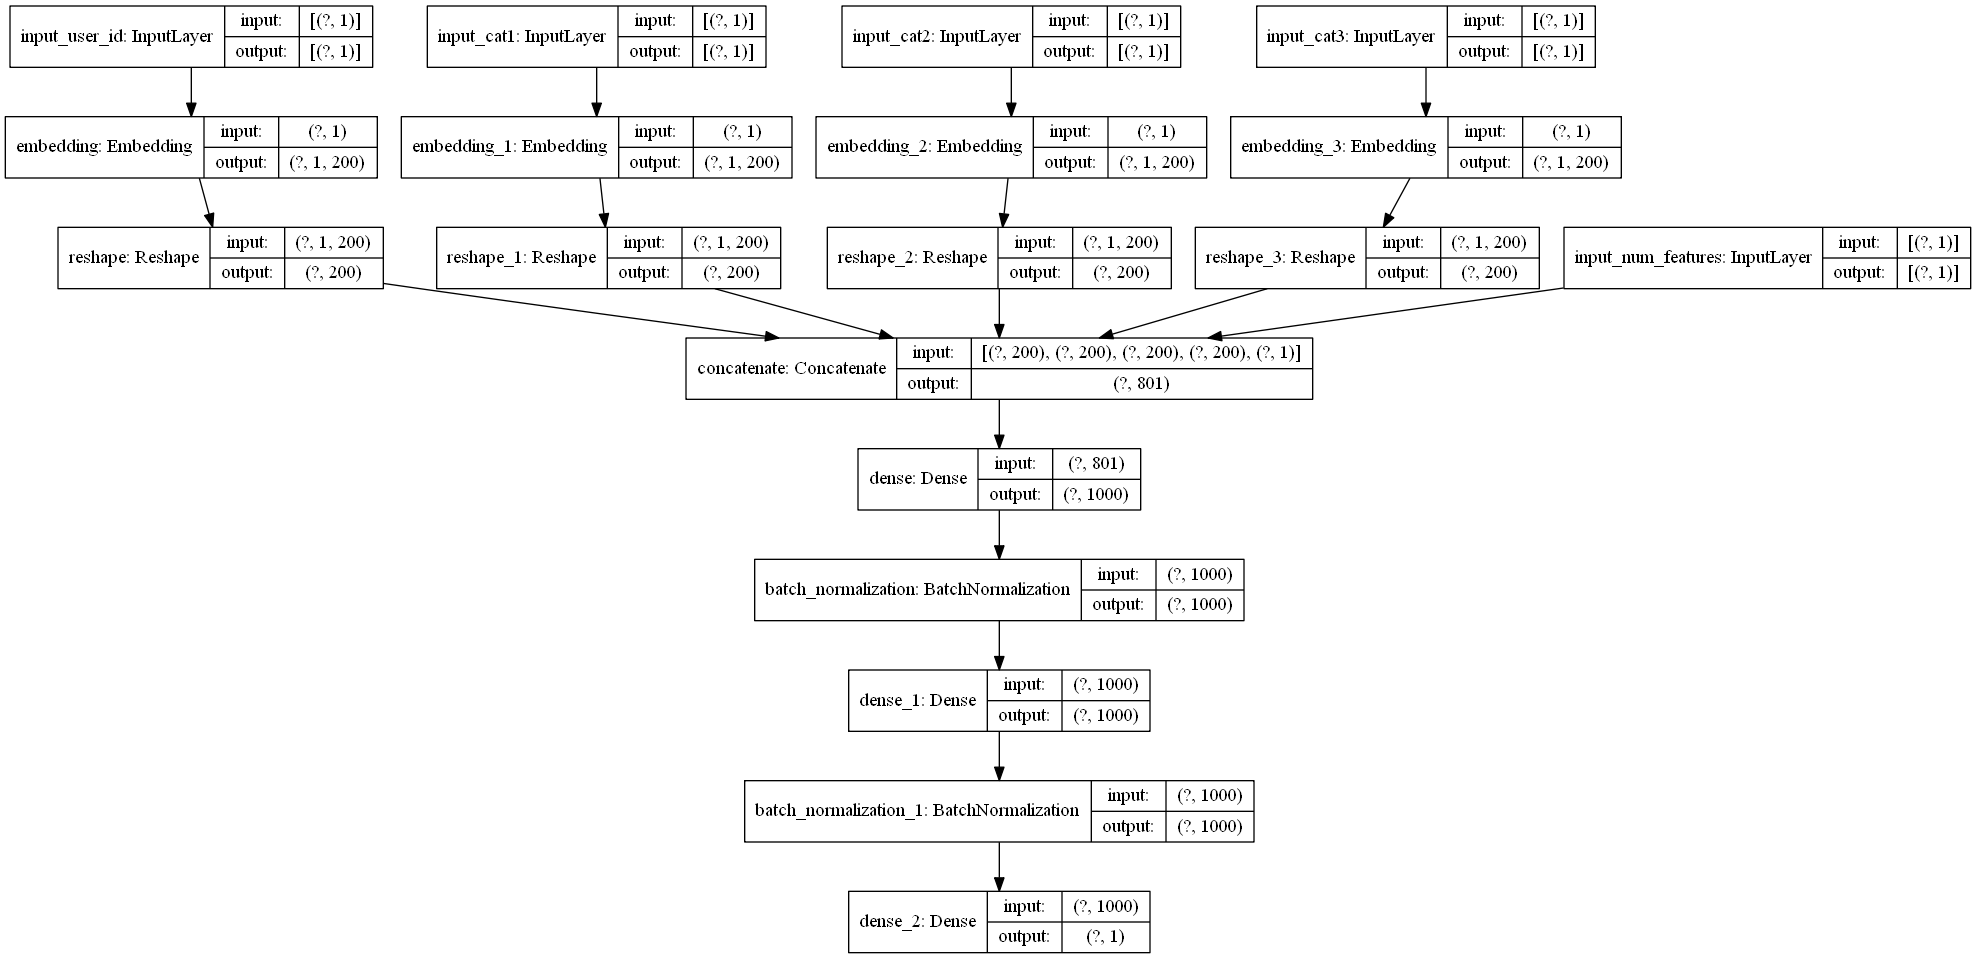

In [12]:
tf_model = create_model(cat_features, num_features, train)
#model.summary()
tf.keras.utils.plot_model(tf_model, 'model.png', show_shapes = True)

## Callbacks

In [13]:
#Learning Rate scheduler
class LearningRateReducerCb(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * 1.02
        print("\nEpoch: {}. Increasing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)
        

class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model = self.model

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model = self.model
                
                
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    """
    from https://github.com/bckenstler/CLR
    
    Copyright (c) 2017 Bradley Kenstler

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:
    
    # About
    This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

## Fit TF model

In [14]:
#dict for training
input_dict= {
    'input_user_id':train[cat_features[0]],
    'input_cat1':train[cat_features[1]],
    'input_cat2':train[cat_features[2]],
    'input_cat3':train[cat_features[3]],
    'input_num_features':train[num_features[0]]
}

# Training Parameters
epochs = 5
batch_size = 1000
val_split = 0.3
save_best_model = SaveBestModel()
clr_triangular = CyclicLR ( base_lr=0.001, 
                            max_lr=0.01,
                            step_size=2.,mode='triangular') 

#fit
history = tf_model.fit(input_dict, 
                       labels*1, 
                       validation_split= val_split, 
                       epochs= epochs, 
                       batch_size= batch_size,   
                       callbacks=[clr_triangular, save_best_model],     #   LearningRateReducerCb() 
                       #shuffle = True
                      )    

Train on 8400 samples, validate on 3600 samples
Epoch 1/5
8400/8400 [==============================] - 2s 207us/sample - loss: 2.6531 - acc: 0.4981 - val_loss: 0.7065 - val_acc: 0.5108
Epoch 2/5
8400/8400 [==============================] - 0s 18us/sample - loss: 0.9327 - acc: 0.4920 - val_loss: 0.7871 - val_acc: 0.4961
Epoch 3/5
8400/8400 [==============================] - 0s 18us/sample - loss: 1.0105 - acc: 0.5074 - val_loss: 1.0920 - val_acc: 0.4947
Epoch 4/5
8400/8400 [==============================] - 0s 18us/sample - loss: 1.1346 - acc: 0.5087 - val_loss: 0.7706 - val_acc: 0.4969
Epoch 5/5
8400/8400 [==============================] - 0s 18us/sample - loss: 0.7457 - acc: 0.5242 - val_loss: 0.7037 - val_acc: 0.4950


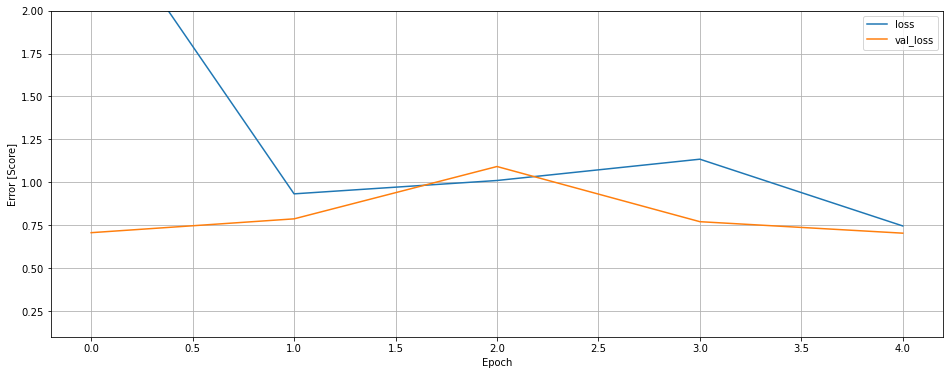

In [15]:
#plot loss history 

def plot_loss(history):
    fig = plt.figure(figsize=(16,6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0.1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Score]')
    plt.legend()
    plt.grid(True)    
    plt.show()

plot_loss(history)

In [16]:
#Save Model H5

#tf_model = save_best_model.best_model    #saves best model

tf.keras.models.save_model(
    tf_model,
    'outputs/tf_model.h5',
    overwrite=True,
    include_optimizer=True,
    save_format='h5',
    signatures=None,
    options=None
)

print('Model Saved')

Model Saved


In [17]:
#Clear TF Session
tf.keras.backend.clear_session()

# Register Models

In [18]:
# #Register TF Model in Azure
# TFmodel = Model.register( workspace=ws,                       
#                            model_name='tf_model',             # Name of the registered model in your workspace.
#                            model_path='outputs/tf_model.h5',  # Local file to upload and register as a model.
#                            description='TensorFlow model on synthetic data',
#                            tags={'area': 'prototype', 'type': 'TensorFlow'})

# print('Name:', TFmodel.name)
# print('Version:', TFmodel.version)

# Load  Models from Azure

In [19]:
# Load TF model

TFmodel = Model(ws, name='tf_model')
print('Name:', TFmodel.name)
print('Version:', TFmodel.version)

Name: tf_model
Version: 1


# Score.py

In [20]:
%%writefile score.py
import joblib
import sklearn
import numpy as np
import os
import json
import pandas as pd
import tensorflow as tf
from azureml.core.model import Model
from sklearn.preprocessing import LabelEncoder
import pandas_validator as pv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import LabelEncoder, StandardScaler


class InputValidator(pv.DataFrameValidator): 
    '''
    Class to test input data validity
    '''
    row_num = 120
    column_num = 6
    userID = pv.IntegerColumnValidator('user_id', min_value=0)
    cat1 = pv.IntegerColumnValidator('cat1', min_value=0, max_value=120)
    cat2 = pv.IntegerColumnValidator('cat2', min_value=0, max_value=3)
    cat3 = pv.IntegerColumnValidator('cat3', min_value=0, max_value=40)
    numeric1 = pv.FloatColumnValidator('numeric1', min_value=0, max_value=10)
    target = pv.FloatColumnValidator('target', min_value=0, max_value=1)
    
    
class TestValidator(pv.DataFrameValidator):  
    '''
    Class to test test data validity
    '''
    row_num = 200
    column_num = 5
    userID = pv.IntegerColumnValidator('user_id', min_value=0)
    cat1 = pv.IntegerColumnValidator('cat1', min_value=0, max_value=120)
    cat2 = pv.IntegerColumnValidator('cat2', min_value=0, max_value=3)
    cat3 = pv.IntegerColumnValidator('cat3', min_value=0, max_value=40)
    numeric1 = pv.FloatColumnValidator('numeric1', min_value=0, max_value=10)
    numeric1 = pv.FloatColumnValidator('numeric1', min_value=0, max_value=10) 
    
    
def prepare_data(data_df, is_train, label_dict, scaler_dict):
    '''
    Process input data from azure
    '''
    data_df.fillna(0) 
        
    #encode features
    cat_features = ['user_id', 'cat1', 'cat2', 'cat3']
    num_features = ['numeric1']
    
    #label encoding
    data_df.replace(label_dict)
    
    #scaling
    for col in num_features:
        (data_df[col] - scaler_dict[col][0]) /  scaler_dict[col][1]
        
    #dict for tf
    df_dict= {
              'input_user_id':data_df[cat_features[0]],
              'input_cat1':data_df[cat_features[1]],
              'input_cat2':data_df[cat_features[2]],
              'input_cat3':data_df[cat_features[3]],
              'input_num_features':data_df[num_features[0]]
              } 
    
    # if true return labels
    if is_train:
        # convert target to cat
        data_df = ewma_to_cat(data_df)
        labels = data_df['target']    
        return df_dict, labels
    
    else:
        return df_dict
    

def ewma_to_cat(df):
    '''
    Convert target to discrete based on IQR
    returns: modified df
    '''    
    q1, q2, q3 = np.percentile(df['target'], [25,50,75])
    df.loc[df['target'] > q2, 'target'] = 1
    df.loc[df['target'] <= q2, 'target'] = 0
    #user_df.loc[(user_df["ewma"] >= q1) & (user_df["ewma"] <= q3), 'ewma'] = 1    #group Q2 and Q3 to make trinary
    df['target'] = df['target'].astype(int)
    return df


def cos_sim(user, user_df):
    '''
    Cosine similarity for users
    '''
    n = 10
    user_row = user_df.loc[user_df['user_id'] == user]
    user_row = user_row.drop(['user_id'], axis = 1)
    
    result_df = pd.DataFrame(user_df['user_id'])
    no_id_df = user_df.drop(['user_id'], axis = 1)

    cos_sim = cosine_similarity(no_id_df, user_row )
    result_df['cos_sim'] = cos_sim
    top_n = result_df[result_df['user_id'] != user].nlargest(10, 'cos_sim')['user_id']    
    return top_n.values


def init():
    '''
    Initialize model and globals
    '''
    global question_df
    global TFmodel      
     
    #Load TF model
    tf_model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'tf_model.h5')
    TFmodel = tf.keras.models.load_model(tf_model_path)   
    

def run(data):  #, test
    '''
    Run script
    ''' 
    
    try:
        #Input Data
        input_data = pd.DataFrame(json.loads(data)['data'])
        test_data =  pd.DataFrame(json.loads(data)['test'])  
        rec_data =   pd.DataFrame(json.loads(data)['rec']) 
        label_dict = json.loads(data, object_hook=lambda d: 
                                {int(k) if k.lstrip('-').isdigit() else k: v for k, v in d.items()})['label_dict']
        scaler_dict = json.loads(data)['scaler_dict']
        
        #Top ten similar users
        user = input_data['user_id'][0]
        top_ten = cos_sim(user, rec_data)
        
    except AssertionError as error:
         return error 

    #Validate Data
    input_validator = InputValidator()
    test_validator = TestValidator()
    
    #user data
    try:
        assert(input_validator.is_valid(input_data))
    except:
        return ('Assertion error, invalid User data')
    
    #question data
    try:
        assert(test_validator.is_valid(test_data))
    except:
        return ('Assertion error, invalid Question data')

    #process input and convert dict and labels
    input_dict, labels = prepare_data(input_data, True, label_dict, scaler_dict)  
    test_dict = prepare_data(test_data, False, label_dict, scaler_dict)

    #append TF model with input data
    TFmodel.fit(input_dict, labels, epochs= 5)    
    result = TFmodel.predict(test_dict)
    
    return result.tolist(), top_ten.tolist()  

Overwriting score.py


# Deploy

In [21]:
'''
Curated Environments List
'''

# envs = Environment.list(workspace=ws)

# for env in envs:
#     if env.startswith("AzureML"):
#         print("Name",env)
#         print("packages", envs[env].python.conda_dependencies.serialize_to_string())

'\nCurated Environments List\n'

In [22]:
#Create Custom Environment with pip

env = Environment('my_env')        

env.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'inference-schema[numpy-support]',
    'joblib',
    'numpy',
    'scikit-learn=={}'.format(skl.__version__),
    'tensorflow =={}'.format(tf.__version__ ),
    'h5py==2.10.0',
    'pandas_validator'
])

In [ ]:
#Deploy Model, run this I removed the output for privacy
service_name = 'simple-local'
mods = [TFmodel]      

inference_config = InferenceConfig(entry_script='score.py', environment=env)

# Deploy options
#aci_config = AciWebservice.deploy_configuration(cpu_cores=2, memory_gb=1)
local_config = LocalWebservice.deploy_configuration(port=8890)                   #Deploy Local, requires Docker running
#aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True)         #cpu_cores = 4, memory_gb = 8
#aks_config2 = AksWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)  #alternate aks

service = Model.deploy(workspace=ws,
                       name=service_name,
                       models= mods,                         
                       inference_config=inference_config,
                       deployment_config= local_config,        
                       #deployment_target= aks_cluster,       # For K8S, from initial creation
                       overwrite=True)
service.wait_for_deployment(show_output=False)  

In [ ]:
#Get Error Logs if service Fails
print(service.get_logs())

In [24]:
#Get URL for local
print(service.scoring_uri) 

http://localhost:8890/score


In [25]:
#%%timeit

#Get Results
input_payload = json.dumps({
    'data': live_df.to_dict(),
    'test': test_df.to_dict(),
    'rec' : recommender_df.to_dict(),
    'label_dict' : label_dict,
    'scaler_dict' : scaler_dict
    #'data': test_df.to_dict(),  #test input validation
    #'method': 'predict'  # 'predict_proba' else 'predict'.
})

 

output = service.run(input_payload)

print(output)

[[[0.102875255048275], [0.6256417036056519], [0.8166980147361755], [0.06229126453399658], [0.07255028933286667], [0.8700805306434631], [0.05808218941092491], [0.27427226305007935], [0.24265877902507782], [0.1904037445783615], [0.8177449703216553], [0.4425472021102905], [0.3032751679420471], [0.6422600746154785], [0.8337113261222839], [0.644760251045227], [0.9527812600135803], [0.623135507106781], [0.2013721466064453], [0.1313440352678299], [0.5220851302146912], [0.2463076263666153], [0.24713481962680817], [0.7322932481765747], [0.24610702693462372], [0.10759633779525757], [0.4224775731563568], [0.8915165066719055], [0.8992987871170044], [0.20888544619083405], [0.06251001358032227], [0.1293996274471283], [0.17920616269111633], [0.2851390838623047], [0.1732848882675171], [0.10876649618148804], [0.9177520275115967], [0.6685217022895813], [0.5593864917755127], [0.7411669492721558], [0.9748287200927734], [0.18991979956626892], [0.709888756275177], [0.15333294868469238], [0.5570212602615356]

# Delete Workspace

In [ ]:
#Delete Workspace, cleanup when finished

#ws.delete()